### TBD

### Archived
- Evaluate OI, PI, MI two variants (statistical and graphical versions)
- Evaluate screening-off in the best DAGs
- PEP8 standard
- create a new plot using the two calibs in `quality_testLoss.png`
- compare the performance of different versions of a graph
- Generate additional datasets with different strengths => compare model powers
- Discuss about Jan's view on entanglement and the effect of mixing datasets on CI-relations
- `plot_stacked_loess` into two parts: (seen vs. unseen) or (conditional vs. marginal)
- data_icm is correlationally very close to the `data_te` => why marginally is not so good?

- `CCC`: classical common cause (c24)
- `SLM`: super-luminal causation (c28)
- `SDM`: super-deterministic model (c27)
- `NSS`: non-separability of states; symmetric retrocausal model(c35)
- `DIS`: disconnected (c0)
- `SAT`: saturated (c16)
- `SCC`: separate common causes (c700) 
- `VIM`: violation of independence of mechanisms (c600)
- `MCC`: multidimensional common cause (c500)


- `ACC`: all pairs with CC (c55)+
- `LSO`: lambda to settings to outcomes SS<=L=>OO (c36)
- `SLO`: settings to lambda to outcomes SS=>L=>OO (c17)
- `TCC`: three classical CCs (c56)
- `VIA`: violation of intervention assumptin (c51)
- `NCP`: Näger cacenling path (c39)
- `OOC`: outcome-to-outcome causation O=>O (c2)
- `SOC`: setting-to-outcome causation S=>O (c3)
- `CCS`: common cause plus superdeterminism (c50)
- `SLC`: single latent confounder (c22)

In [1]:
import os
import pandas as pd
import numpy as np
import torch as th
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import itertools
import collections
import sys
from torch.utils.data import DataLoader

sys.path.insert(1, '../Scripts')
import distance_functions as dFun
import utilities_functions as uFun
import visualization_functions as vFun
import evaluator as eFun

In [2]:
cr_seen = ['MMD_cdt', 'CorrD', 'CndD']
cr_unseen = ['MMD_Fr', 'BinnedD', 'CorrD_N', 'NpMom', 'EDF_Mrg']
cr_names = cr_mixed = cr_seen + cr_unseen
#['MMD_cdt', 'MMD_Fr', 'CorrD', 'BinnedD', 'CorrD_N', 'NpMom', 'CndD', 'EDF_Mrg']

container = uFun.prepare_results(
    results_dir='../Results/', 
    data_dir='../Data/', 
    cr_names=cr_mixed,
    weight_cr=True,  
    reduction='mean',
    handle_outliers=True,
)
df = uFun.container_to_df(container)

df_sep_perfs = uFun.get_separate_performances(
    results_dir='../Results/', 
    data_dir='../Data/', 
    weight_cr=True, 
    reduction='mean',
    handle_outliers=True,
)

nl_dict = {
    'c500':'MCC', 'c28':'SLM', 'c700':'SCC', 'c27':'SDM', 'c51':'VIA', 'c600':'VIM', 'c35':'NSS', 'c24':'CCC', 
    'c16':'SAT', 'c39':'NCP', 'c56':'TCC', 'c50':'CCS', 'c55':'ACC', 'c2': 'OOC', 'c36':'LSO', 'c3':'SOC', 
    'c17':'SLO', 'c22':'SLC', 'c0':'DIS',}
ln_dict = {v: k for k, v in nl_dict.items()}

labels1 = ['SAT', 'MCC', 'SLM', 'SDM', 'SCC', 'NSS', 'VIM', 'CCC', 'DIS']
names1  = [ln_dict[l] for l in labels1]
#labels2 = ['NCP', 'TCC', 'ACC', 'VIA', 'LSO', 'SLC', 'SLO', 'CCS', 'OOC', 'SOC']
#names2  = [ln_dict[l] for l in labels2]
labels = labels1; names = names1


df1 = df.set_index('cand_name').loc[names1,:]
df1['label'] = labels1
df1 = df1.set_index('label')
container1 = {nl_dict[k]:v for k,v in container.items() if k in names1}
for key in container1.keys():
    container1[key]['syn_data'] = th.Tensor(pd.read_csv(container1[key]['syn_link']).values[:, :4])

In [3]:
data_org = pd.read_csv('../Data/datasets/dat_test.csv').values
data_tr = th.Tensor(pd.read_csv('../Data/datasets/dat_train.csv').values)
data_te = th.Tensor(pd.read_csv('../Data/datasets/dat_test.csv').values)

data_mcc = pd.read_csv('../Results/qcm/synthetic/c0.csv').values
loss_tr_mcc = pd.read_csv('../Results/qcm/losses/train/c0_r2.csv')
loss_va_mcc = pd.read_csv('../Results/qcm/losses/valid/c0_r2.csv')
loss_te_mcc = pd.read_csv('../Results/qcm/losses/test/c0_r2.csv')

data_ccc = pd.read_csv('../Results/ccm/synthetic/c24.csv').values
loss_tr_ccc = pd.read_csv('../Results/ccm/losses/train/c24_r1.csv')
loss_va_ccc = pd.read_csv('../Results/ccm/losses/valid/c24_r1.csv')
loss_te_ccc = pd.read_csv('../Results/ccm/losses/test/c24_r1.csv')

data_scc = pd.read_csv('../Results/scc/synthetic/c0.csv').values
loss_tr_scc = pd.read_csv('../Results/scc/losses/train/c0_r3.csv')
loss_va_scc = pd.read_csv('../Results/scc/losses/valid/c0_r3.csv')
loss_te_scc = pd.read_csv('../Results/scc/losses/test/c0_r3.csv')

### Marginal Independence in D_org

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


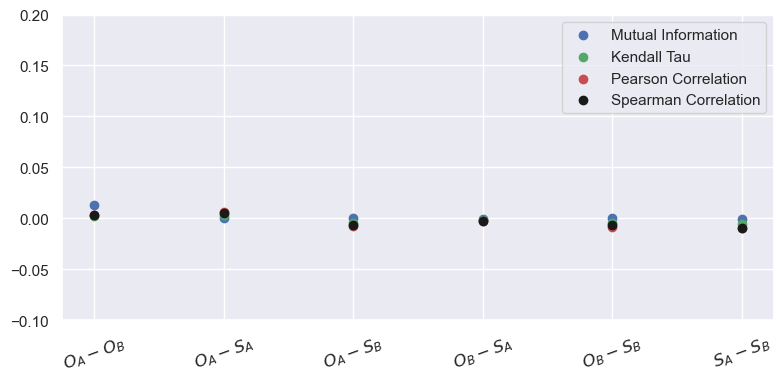

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
meas_dict = vFun.visualize_marginal_distance(
    data=data_org, 
    ax=ax)
ax.set_ylim(-0.1, +0.2)
ax.set_xticks(np.arange(len(meas_dict)), meas_dict.keys(), rotation=20, fontsize=12)
ax.legend()
plt.savefig('../Plots/indep_marginal_org.png', dpi=300)
plt.show()
plt.close()

### Learning Progress

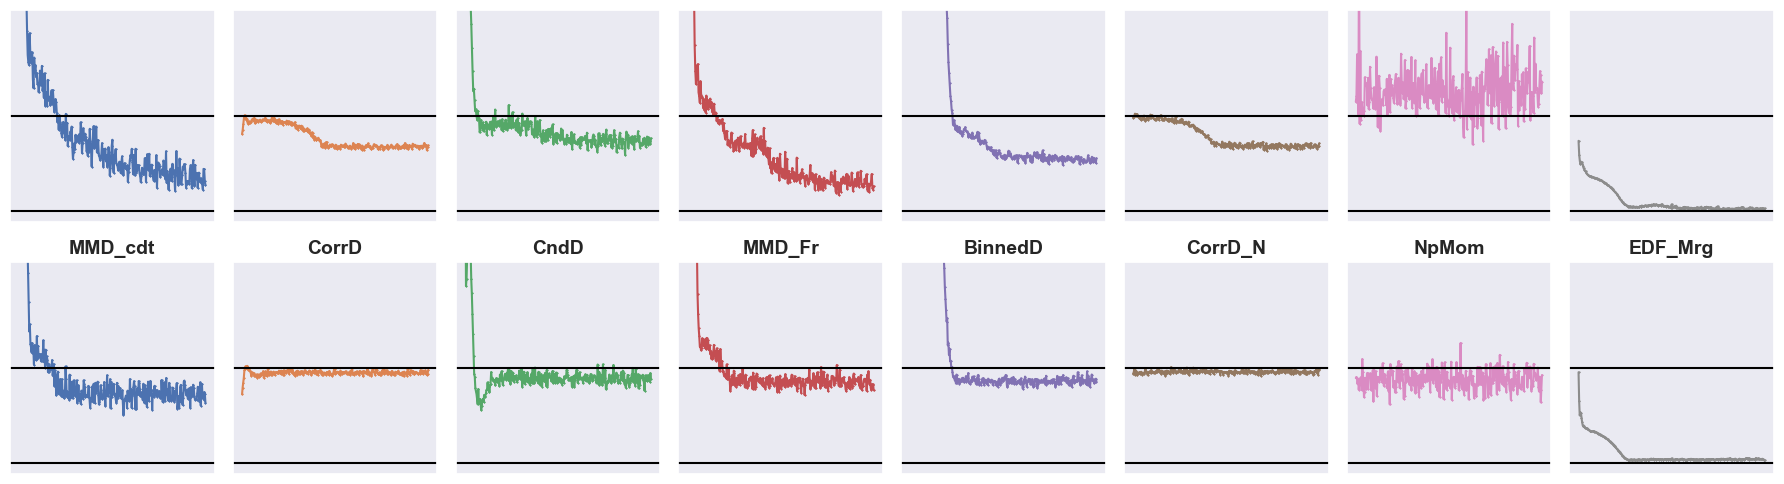

In [8]:
labels = [ 'CCC', 'DIS']
n_labels = len(labels)
n_criteria = len(cr_names)

fig, axes = plt.subplots(nrows=n_labels, ncols=n_criteria, sharey=True, sharex=False, figsize=(18, 5), tight_layout=True)

for index, label in enumerate(labels):
    name = ln_dict[label]
    loss_va_link = list(df[df.cand_name==name].loss_va_link)[0]
    loss_va = pd.read_csv(loss_va_link)
    vFun.plot_progress(df=loss_va, cr_names=cr_names, axes=axes[index,:])
for i, cr_name in enumerate(cr_names):
    axes[1, i].set_title(cr_name, fontsize=14, weight='bold')
#plt.savefig('../Plots/loss_progress.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Marginal Distribuitons

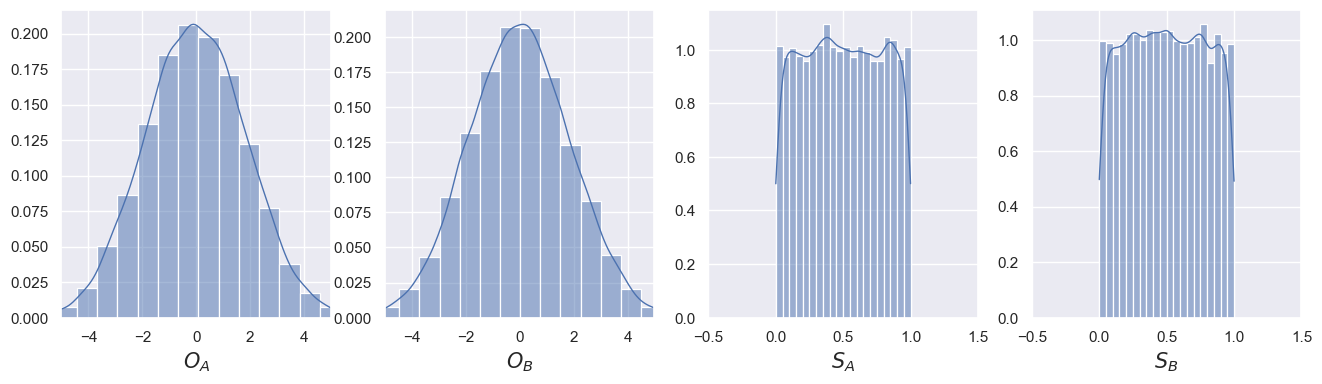

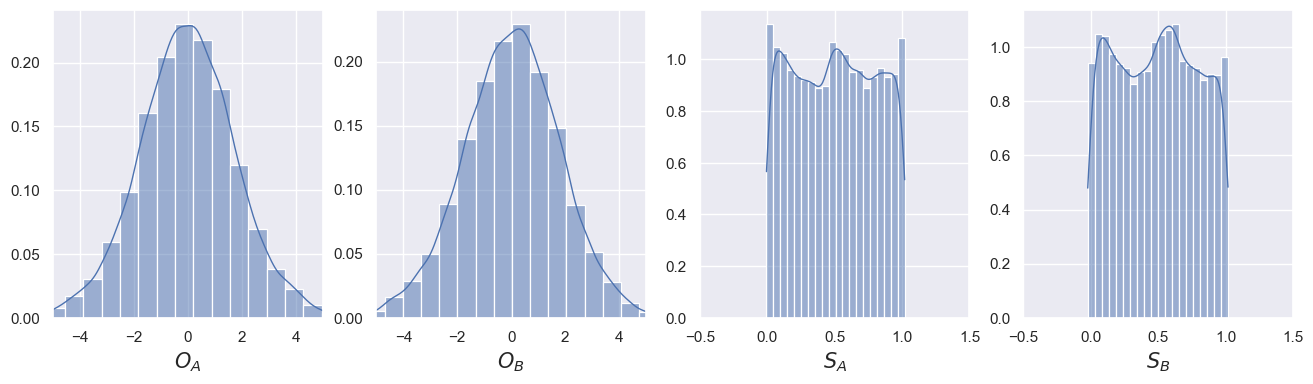

In [18]:
vFun.plot_marginals(
    data=data_org, 
    saving_path='../Plots/marginals_org.png',
)

vFun.plot_marginals(
    data=data_ccc[:,:4], 
    saving_path='../Plots/marginals_dis.png',
)

### Condtional Independence Tests

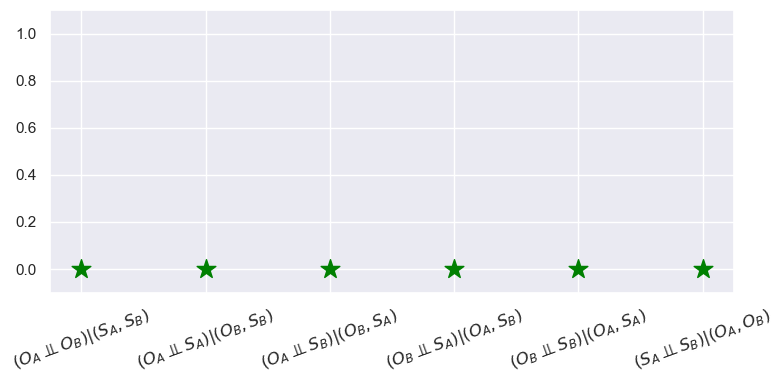

In [30]:
# conditioal independence tests

fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
n_points = 15000
ax.set_ylim(-0.1, +1.1)

pval_dict = vFun.plot_indep_tests(
    data_org[:n_points, :], 
    test_type=2, 
    ax=ax, 
    num_perm=100, 
    marker='*', 
    color='#008001',
    label='Original',
)

#ax.legend()
ax.set_xticks(np.arange(len(pval_dict)), pval_dict.keys(), rotation=20, fontsize=12)
plt.savefig('../Plots/citests_org.png', dpi=300)
plt.show()
plt.close()

### Condtional Heatmaps 

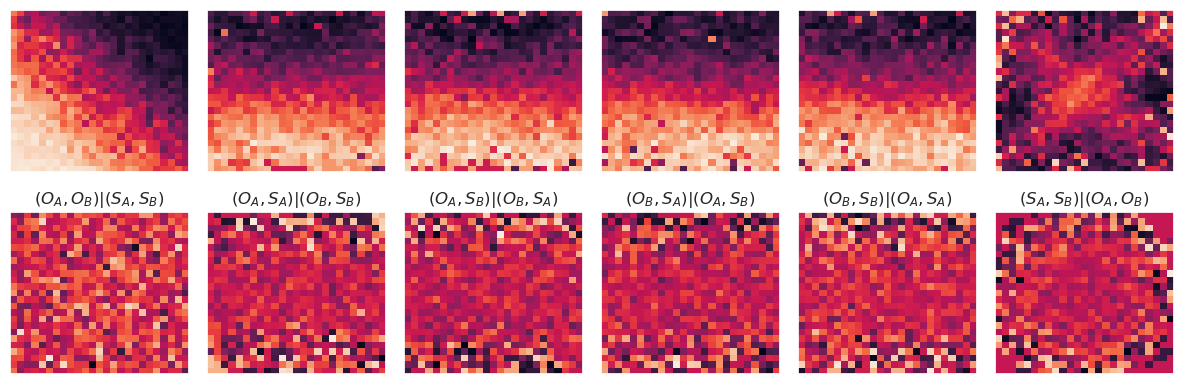

In [12]:
sampling_rate = 25
labels = ['SLM', 'CCC']#'SCC', 'VIM', 
n_labels = len(labels)
fig, axes = plt.subplots(n_labels, 6, figsize=(12, 4), tight_layout=True,)

for index, label in enumerate(labels):
    name = ln_dict[label]
    syn_link = list(df[df.cand_name==name].syn_link)[0]
    data_pred = pd.read_csv(syn_link).values[:, :4]
    legend_dict = vFun.plot_heatmaps(data_pred, axes[index], sampling_rate=sampling_rate)

for i, (conditional, label) in enumerate(legend_dict.items()):
    axes[1, i].set_title(label, fontsize=12, weight='bold')
plt.savefig('../Plots/heatmaps_merged.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### Performance Overview 
### Performance on Datasets: train vs. test 
### Performance on Measures: seen vs. unseen 

In [7]:
candidates_list = ['SAT', 'SLM', 'SDM', 'SCC', 'NSS', 'VIM', 'CCC', 'DIS']

measures_list = [dFun.MMD_cdt(bandwidth=[1]), dFun.MMD_Fourier(bandwidths=[0.1, 1, 10, 100], n_RandComps=100), dFun.CorrD([1, 1], 3), dFun.BinnedD('JS', 4), dFun.CorrD_N(), dFun.NpMom(num_moments=3, weighting_exp=2), 
                 dFun.CndD(sample_weighting=True, sampling_rate=3, num_std_moments=4, weighting_exp=1), dFun.EDF_Marg('AD'),]
cr_names = [m.get_name(True) for m in measures_list]
n_epochs = calib_epochs = 100

raw_loss_tr = uFun.evaluate_candidates(candidates_list, measures_list, data_tr, n_epochs, container1)
raw_loss_te = uFun.evaluate_candidates(candidates_list, measures_list, data_te, n_epochs, container1)
calib_tr = uFun.get_calibs(data_tr, measures_list, calib_epochs)
calib_te = uFun.get_calibs(data_te, measures_list, calib_epochs)
loss_tr = uFun.calibrate_loss(raw_loss_tr, calib_tr)
loss_te = uFun.calibrate_loss(raw_loss_te, calib_te)

df_tr = pd.DataFrame(loss_tr.mean(2), index=candidates_list, columns=cr_names,)
df_te = pd.DataFrame(loss_te.mean(2), index=candidates_list, columns=cr_names,)

ids_tr = [i for i, m in enumerate(cr_names) if m in cr_seen] 
ids_un = [i for i, m in enumerate(cr_names) if m in cr_unseen]
ids_te = [i for i in range(len(cr_names))]

loss_dataTR_measTR = loss_tr[:, ids_tr, :]
loss_dataTR_measUN = loss_tr[:, ids_un, :]
loss_dataTR_measTE = loss_tr[:, ids_te, :]
loss_dataTE_measTR = loss_te[:, ids_tr, :]
loss_dataTE_measUN = loss_te[:, ids_un, :]
loss_dataTE_measTE = loss_te[:, ids_te, :]


df = pd.DataFrame(index=candidates_list)
df['avg_dataTR_measTR'] = loss_dataTR_measTR.mean(2).mean(1)
df['avg_dataTE_measTR'] = loss_dataTE_measTR.mean(2).mean(1)
df['avg_dataTR_measUN'] = loss_dataTR_measUN.mean(2).mean(1)
df['avg_dataTE_measUN'] = loss_dataTE_measUN.mean(2).mean(1)
df['avg_dataTR_measTE'] = loss_dataTR_measTE.mean(2).mean(1)
df['avg_dataTE_measTE'] = loss_dataTE_measTE.mean(2).mean(1)

df['std_dataTR_measTR'] = loss_dataTR_measTR.std(2).mean(1)
df['std_dataTE_measTR'] = loss_dataTE_measTR.std(2).mean(1)
df['std_dataTR_measUN'] = loss_dataTR_measUN.std(2).mean(1)
df['std_dataTE_measUN'] = loss_dataTE_measUN.std(2).mean(1)
df['std_dataTR_measTE'] = loss_dataTR_measTE.std(2).mean(1)
df['std_dataTE_measTE'] = loss_dataTE_measTE.std(2).mean(1)

df.to_csv('../Results/analysis/performance_report_100.csv', index=True, index_label='candidates')
df_tr.to_csv('../Results/analysis/performance_report_tr_100.csv', index=True, index_label='candidates')
df_te.to_csv('../Results/analysis/performance_report_te_100.csv', index=True, index_label='candidates')

df

,avg_dataTR_measTR,avg_dataTE_measTR,avg_dataTR_measUN,avg_dataTE_measUN,avg_dataTR_measTE,avg_dataTE_measTE,std_dataTR_measTR,std_dataTE_measTR,std_dataTR_measUN,std_dataTE_measUN,std_dataTR_measTE,std_dataTE_measTE
SAT,0.343842,0.598224,3.607654,4.757585,2.383725,3.197824,0.051105,0.059536,0.542457,0.473925,0.358200,0.318529
SLM,0.174051,0.502984,1.309158,1.992505,0.883493,1.433934,0.057643,0.072175,0.429266,0.346497,0.289907,0.243626
SDM,0.548077,0.788279,1.553352,2.287776,1.176374,1.725465,0.069850,0.060520,0.274819,0.315398,0.197956,0.219819
SCC,1.125226,1.486164,2.081009,2.929995,1.722591,2.388558,0.063129,0.054760,0.117965,0.178085,0.097401,0.131838
NSS,0.785769,1.081941,6.658149,7.263858,4.456007,4.945639,0.054468,0.052314,2.332069,2.123517,1.477969,1.346816
VIM,0.690253,0.985009,2.909552,3.734533,2.077315,2.703462,0.097880,0.104739,0.397746,0.315519,0.285296,0.236477
CCC,3.241937,3.904900,5.186654,6.199449,4.457386,5.338993,0.052475,0.058423,0.323768,0.260149,0.222033,0.184502
DIS,3.157165,3.775003,5.217570,6.170779,4.444918,5.272364,0.052161,0.059477,0.362212,0.234328,0.245943,0.168759


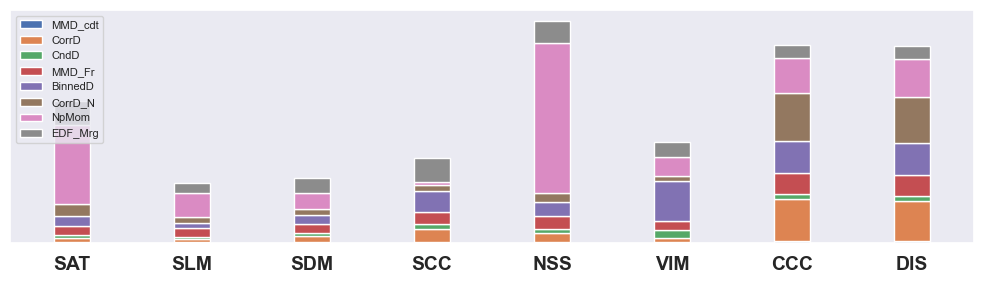

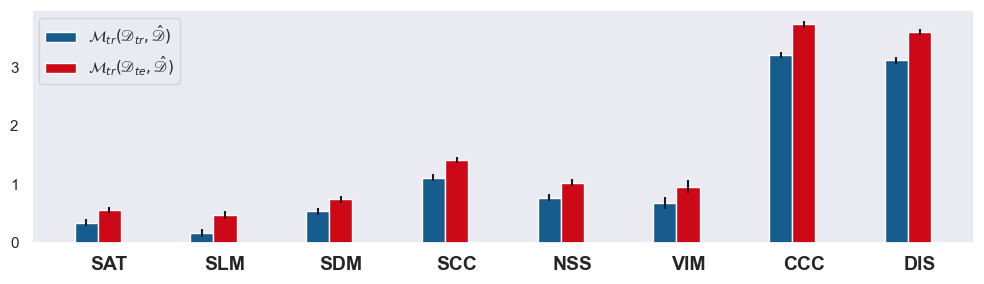

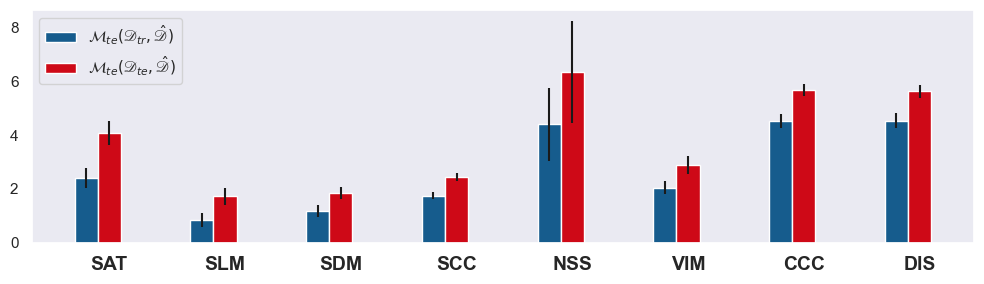

In [66]:
candidates_list = ['SAT', 'SLM', 'SDM', 'SCC', 'NSS', 'VIM', 'CCC', 'DIS']
cr_names = ['MMD_cdt', 'CorrD', 'CndD', 'MMD_Fr', 'BinnedD', 'CorrD_N', 'NpMom', 'EDF_Mrg']


df = pd.read_csv('../Results/analysis/performance_report_100.csv').set_index('candidates').loc[candidates_list, :]
df_tr = pd.read_csv('../Results/analysis/performance_report_tr_100.csv').set_index('candidates').loc[candidates_list, :]
df_te = pd.read_csv('../Results/analysis/performance_report_te_100.csv').set_index('candidates').loc[candidates_list, :]


vFun.plot_stacked_loess(
    df=df_te, 
    candidates_list=candidates_list, 
    cr_names=cr_names,
    saving_path='../Plots/performance_overview.png',
)

vFun.plot_candidate_losses(
    df=df, 
    candidates_list=candidates_list, 
    comparison_strings_list=['dataTR_measTR', 'dataTE_measTR'], 
    colors_list=['#165C8D', '#CE0917', '#167F0F'],
    show_errors=True, 
    saving_path='../Plots/performance_datasets.png',
)

vFun.plot_candidate_losses(
    df=df, 
    candidates_list=candidates_list, 
    comparison_strings_list=['dataTR_measTE', 'dataTE_measTE'], 
    colors_list=['#165C8D', '#CE0917', '#167F0F'], 
    show_errors=True, 
    saving_path='../Plots/performance_measures.png',
)

### Performance on CndX

In [42]:
n_epochs = 100
n_outputs = 10
batch_size = 8000
n_batches = 2
data_true = data_te
measure = dFun.CndDX(sample_weighting=True, sampling_rate=3, num_std_moments=4, weighting_exp=1)
measure.preallocate_memory(batch_size)
candidates_list = ['SAT', 'SLM', 'SDM', 'SCC', 'NSS', 'VIM', 'CCC', 'DIS']
relation_types=['(1,0)', '(1,1)', '(1,2)', '(1,3)', '(2,0)', '(2,1)', '(2,2)', '(3,0)', '(3,1)', '(4,0)',]
n_candidates = len(candidates_list)
df = pd.DataFrame(index=candidates_list, columns=relation_types)
value_calib = uFun.get_calibX(data_te, measure, n_epochs, n_outputs)
loss_tensor = th.zeros(n_candidates, n_outputs, n_epochs, n_batches)
for index_candidate, candidate in enumerate(candidates_list):
    data_pred = container1[candidate]['syn_data']
    for index_epoch in range(n_epochs):
        loader_true = DataLoader(data_true, batch_size=batch_size, shuffle=True, drop_last=True)
        loader_pred = DataLoader(data_pred, batch_size=batch_size, shuffle=True, drop_last=True)
        for index_batch, (batch_true, batch_pred) in enumerate(zip(loader_true, loader_pred)):
            value_raw = measure._forward_implementation(batch_true, batch_pred)
            loss_calib = (value_raw/value_calib)-1
            loss_calib[loss_calib<0]=0
            loss_tensor[index_candidate, :, index_epoch, index_batch] = loss_calib
    df.iloc[index_candidate,:] = loss_tensor[index_candidate].mean(2).mean(1)
df.to_csv('../Results/analysis/performance_cndx_100.csv', index=True, index_label='candidates')

df

,"(1,0)","(1,1)","(1,2)","(1,3)","(2,0)","(2,1)","(2,2)","(3,0)","(3,1)","(4,0)"
SAT,2.047252,1.416947,0.923154,1.480486,2.047252,1.539696,1.156791,2.047252,1.832603,2.047252
SLM,2.654724,1.374903,1.425246,0.898238,2.654725,1.63666,1.248276,2.654725,1.915698,2.654723
SDM,2.578355,1.510979,1.714277,1.423236,2.578355,1.685884,1.389259,2.578355,1.709589,2.578353
SCC,2.321728,1.801107,2.968004,3.616333,2.321728,6.899168,2.753215,2.321728,1.690782,2.321726
NSS,4.416509,2.159438,1.627183,1.970521,4.416509,2.586783,1.653456,4.416509,2.520055,4.416507
VIM,2.33124,2.780396,4.912553,7.445413,2.33124,4.279351,4.124072,2.33124,3.767231,2.331239
CCC,4.950686,2.024852,4.443583,3.926993,4.950686,2.24765,3.623166,4.950686,3.836384,4.950684
DIS,3.219451,1.185012,4.172106,3.624845,3.219451,1.337436,3.320081,3.219451,3.45349,3.219449


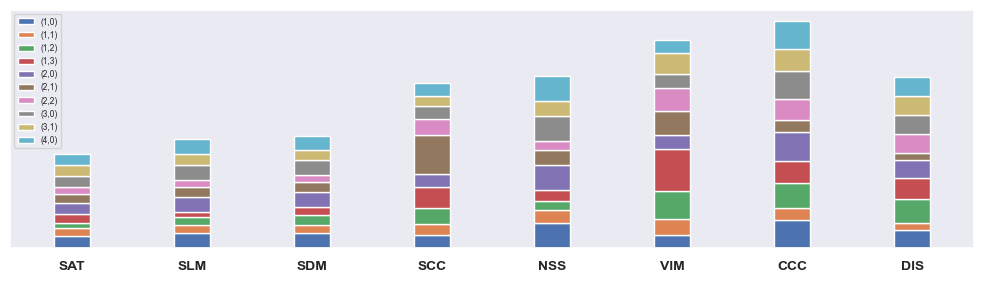

In [68]:
candidates_list = ['SAT', 'SLM', 'SDM', 'SCC', 'NSS', 'VIM', 'CCC', 'DIS']
relation_types=['(1,0)', '(1,1)', '(1,2)', '(1,3)', '(2,0)', '(2,1)', '(2,2)', '(3,0)', '(3,1)', '(4,0)',]
df = pd.read_csv('../Results/analysis/performance_cndx_100.csv').set_index('candidates').loc[candidates_list, :]


vFun.plot_cndDX(
    df=df, 
    candidates_list=candidates_list, 
    relation_types=relation_types, 
    saving_path='../Plots/performance_cndx.png',
)

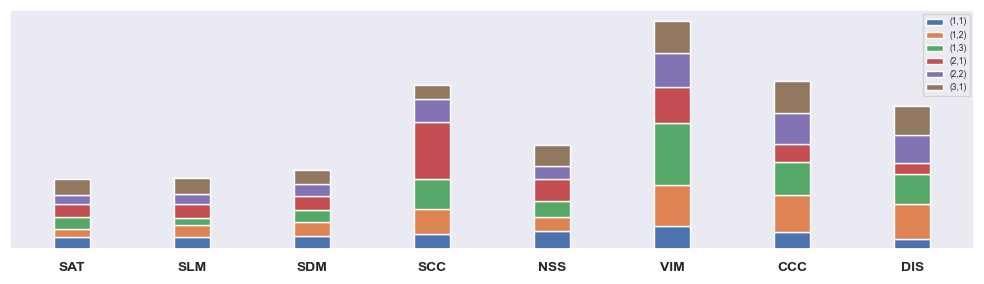

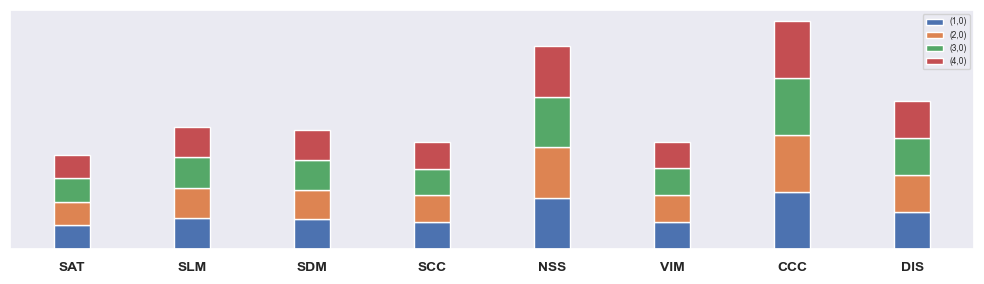

In [53]:
relation_types=[
    #'(1,0)', 
    '(1,1)', 
    '(1,2)', 
    '(1,3)', 
    #'(2,0)', 
    '(2,1)', 
    '(2,2)', 
    #'(3,0)', 
    '(3,1)', 
    #'(4,0)',
]

vFun.plot_cndDX(
    df=df, 
    candidates_list=candidates_list, 
    relation_types=relation_types, 
    #saving_path='../Plots/performance_cndx.png',
)

relation_types=[
    '(1,0)', 
    #'(1,1)', 
    #'(1,2)', 
    #'(1,3)', 
    '(2,0)', 
    #'(2,1)', 
    #'(2,2)', 
    '(3,0)', 
    #'(3,1)', 
    '(4,0)',
]

vFun.plot_cndDX(
    df=df, 
    candidates_list=candidates_list, 
    relation_types=relation_types, 
    #saving_path='../Plots/performance_cndx.png',
)

### Conditional Portions

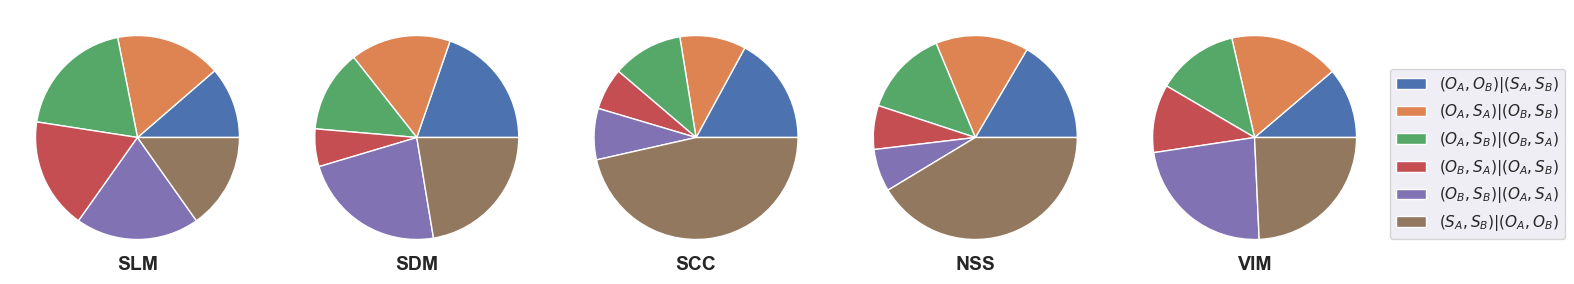

In [40]:
#candidates_list = ['SLM', 'SCC', 'VIM', 'CCC']
candidates_list = ['SLM', 'SDM', 'SCC', 'NSS', 'VIM']
sampling_rate=3
fig, axes = plt.subplots(1, len(candidates_list), figsize=(16, 3), tight_layout=True)
for index, candidate in enumerate(candidates_list):
    data_pred = container1[candidate]['syn_data']
    ax = axes[index]
    ax.text(s=candidate, x=0.5, y=0, fontsize=14, fontweight='bold', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes,)
    
    distances = vFun.plot_conditionals(
        data_true=data_org,
        data_pred=data_pred,
        sampling_rate=sampling_rate, 
        corr_type='(2,2)',
        ax=ax,
    )
axes[-1].legend(list(distances.keys()), fontsize=11, bbox_to_anchor=(1, .8))
plt.savefig('../Plots/conditional_portions.png', dpi=300)
plt.show()
plt.close()

In [23]:
distances

{'$(O_A, O_B)|(S_A, S_B)$': 0.5040055,
 '$(O_A, S_A)|(O_B, S_B)$': 0.22928627,
 '$(O_A, S_B)|(O_B, S_A)$': 0.22536348,
 '$(O_B, S_A)|(O_A, S_B)$': 0.2225283,
 '$(O_B, S_B)|(O_A, S_A)$': 0.22499955,
 '$(S_A, S_B)|(O_A, O_B)$': 0.2289949}

In [ ]:
from scipy import linalg as la
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn; from sklearn.model_selection import train_test_split; from sklearn.ensemble import RandomForestClassifier; from sklearn.neural_network import MLPClassifier
sns.set()

a_y = 1
b_y = 0
E_y = 1 * np.random.uniform(low=-1, high=+1, size=2000).reshape(-1,1)
X = np.random.uniform(low=-1, high=+1, size=2000).reshape(-1,1)
Y = a_y*X + b_y + E_y


s = .2
c = 'black'
rotation=90
fontsize=15
linewidth=3

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4),)

ax[0].scatter(X[:1000], Y[:1000], s=s, c=c)

#ax[0].set_xticks(None) 
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].set_xticks([]); ax[1].set_yticks([])
ax[2].set_xticks([]); ax[2].set_yticks([])

ax[0].set_xlabel('$X$', fontsize=fontsize); ax[0].set_ylabel('$Y$', rotation=rotation, fontsize=fontsize)
ax[1].set_xlabel('$X$', fontsize=fontsize); ax[1].set_ylabel('$\hat{Y}-Y$', rotation=rotation, fontsize=fontsize)
ax[2].set_xlabel('$Y$', fontsize=fontsize); ax[2].set_ylabel('$\hat{X}-X$', rotation=rotation, fontsize=fontsize)

reg_xy = LinearRegression().fit(X[:1000], Y[:1000,0])
X_true = X[1000:]
Y_true = Y[1000:].reshape(-1)
Y_pred = reg_xy.predict(X_true)
E_y = Y_pred-Y_true
ax[0].plot(X_true, Y_pred, '-r', label='$(X, \hat{Y})$', linewidth=linewidth)
ax[1].scatter(E_y, X_true, s=s, c=c)
print(reg_xy.intercept_, reg_xy.coef_)

reg_yx = LinearRegression().fit(Y[:1000], X[:1000,0])
X_true = X[1000:].reshape(-1)
Y_true = Y[1000:]
X_pred = reg_yx.predict(Y_true)
E_x = X_pred-X_true
ax[0].plot(X_pred, Y_true, '-b', label='$(\hat{X}, Y)$', linewidth=linewidth)
ax[2].scatter(E_x, Y_true, s=s, c=c)

ax[0].legend(loc='upper left')

plt.savefig('asymmetry_statistical.png', dpi=300, bbox_inches='tight')
plt.show()